In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import string
import torch.nn as nn
from deepchem.feat.smiles_tokenizer import SmilesTokenizer
import sklearn
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from openbabel import pybel

In [116]:
dropcols = ['Reaction_No', 'Reactant_1_Short_Hand', 'Reactant_1_eq', 
            'Reactant_1_mmol', 'Reactant_2_eq', 'Reactant_2_eq', 
            'Catalyst_1_Short_Hand', 'Catalyst_1_eq', 'Ligand_eq', 
            'Reagent_1_eq', 'Product_Yield_Mass_Ion_Count', 'Unnamed: 16', 
            'Unnamed: 17']

df = pd.read_csv('aap9112_data_file_s1.csv').drop(labels=dropcols, axis=1)
df['Reagent_1_Short_Hand'] = pd.Categorical(df['Reagent_1_Short_Hand']).codes
df['Solvent_1_Short_Hand'] = pd.Categorical(df['Solvent_1_Short_Hand']).codes
df['Ligand_Short_Hand'] = df['Ligand_Short_Hand'].str.strip()
df['Reactant_2_Name'] = df['Reactant_2_Name'].str.strip()
df['Reactant_1_Name'] = df['Reactant_1_Name'].str.strip()

In [117]:
ligands = {
    'P(tBu)3' : 'CCCCP(CCCC)CCCC',
    'P(Ph)3' : 'c3ccc(P(c1ccccc1)c2ccccc2)cc3',
    'AmPhos' : 'CN(C)c1ccc(P(C(C)(C)C)C(C)(C)C)cc1',
    'P(Cy)3' : 'C3CCC(P(C1CCCCC1)C2CCCCC2)CC3',
    'P(o-Tol)3' : 'Cc1ccccc1P(c2ccccc2C)c3ccccc3C',
    'CataCXium A' : 'CCCCP(C12C[C@H]3C[C@@H](C1)C[C@@H](C2)C3)C12C[C@H]3C[C@@H](C1)C[C@@H](C2)C3',
    'SPhos' : 'COc1cccc(c1c2ccccc2P(C3CCCCC3)C4CCCCC4)OC',
    'dtbpf' : 'CC(C)(C)[PH+](C1=CC=C[CH-]1)C(C)(C)C.CC(C)(C)[PH+](C1=CC=C[CH-]1)C(C)(C)C.[Fe+2]',
    'XPhos' : 'P(c2ccccc2c1c(cc(cc1C(C)C)C(C)C)C(C)C)(C3CCCCC3)C4CCCCC4',
    'dppf' : 'C1=CC=C(C=C1)P([C-]2C=CC=C2)C3=CC=CC=C3.C1=CC=C(C=C1)P([C-]2C=CC=C2)C3=CC=CC=C3.[Fe+2]',
    'Xantphos' : 'O6c1c(cccc1P(c2ccccc2)c3ccccc3)C(c7cccc(P(c4ccccc4)c5ccccc5)c67)(C)C',
    'None' : ''
}

reactant_1 = {
    '6-chloroquinoline' : 'Clc2ccc1ncccc1c2', 
    '6-Bromoquinoline' : 'Brc2ccc1ncccc1c2', 
    '6-triflatequinoline' : 'O=S(=O)(Oc2ccc1ncccc1c2)C(F)(F)F',
    '6-Iodoquinoline' : 'Ic2ccc1ncccc1c2', 
    '6-quinoline-boronic acid hydrochloride' : 'OB(O)c2ccc1ncccc1c2',
    'Potassium quinoline-6-trifluoroborate' : '[K+].F[B-](F)(F)c1ccc2ncccc2c1',
    '6-Quinolineboronic acid pinacol ester' : 'CC3(C)OB(c2ccc1ncccc1c2)OC3(C)C'
}

reactant_2 = {
    '2a, Boronic Acid' : 'Cc3ccc1c(cnn1C2CCCCO2)c3B(O)O', 
    '2b, Boronic Ester' : 'Cc3ccc1c(cnn1C2CCCCO2)c3B4OC(C)(C)C(C)(C)O4', 
    '2c, Trifluoroborate' : '[K+].Cc3ccc1c(cnn1C2CCCCO2)c3[B-](F)(F)F',
    '2d, Bromide' : 'Cc3ccc1c(cnn1C2CCCCO2)c3Br'
}

In [118]:
df['Ligand_Short_Hand'] = df['Ligand_Short_Hand'].replace(ligands)
df['Reactant_1_Name'] = df['Reactant_1_Name'].replace(reactant_1)
df['Reactant_2_Name'] = df['Reactant_2_Name'].replace(reactant_2)
df

,Reactant_1_Name,Reactant_2_Name,Ligand_Short_Hand,Reagent_1_Short_Hand,Solvent_1_Short_Hand,Product_Yield_PCT_Area_UV
0,Clc2ccc1ncccc1c2,Cc3ccc1c(cnn1C2CCCCO2)c3B(O)O,CCCCP(CCCC)CCCC,6,1,4.76
1,Clc2ccc1ncccc1c2,Cc3ccc1c(cnn1C2CCCCO2)c3B(O)O,c3ccc(P(c1ccccc1)c2ccccc2)cc3,6,1,4.12
2,Clc2ccc1ncccc1c2,Cc3ccc1c(cnn1C2CCCCO2)c3B(O)O,CN(C)c1ccc(P(C(C)(C)C)C(C)(C)C)cc1,6,1,2.58
3,Clc2ccc1ncccc1c2,Cc3ccc1c(cnn1C2CCCCO2)c3B(O)O,C3CCC(P(C1CCCCC1)C2CCCCC2)CC3,6,1,4.44
4,Clc2ccc1ncccc1c2,Cc3ccc1c(cnn1C2CCCCO2)c3B(O)O,Cc1ccccc1P(c2ccccc2C)c3ccccc3C,6,1,1.95
...,...,...,...,...,...,...
5755,CC3(C)OB(c2ccc1ncccc1c2)OC3(C)C,Cc3ccc1c(cnn1C2CCCCO2)c3Br,CC(C)(C)[PH+](C1=CC=C[CH-]1)C(C)(C)C.CC(C)(C)[...,2,0,47.21
5756,CC3(C)OB(c2ccc1ncccc1c2)OC3(C)C,Cc3ccc1c(cnn1C2CCCCO2)c3Br,P(c2ccccc2c1c(cc(cc1C(C)C)C(C)C)C(C)C)(C3CCCCC...,2,0,0.00
5757,CC3(C)OB(c2ccc1ncccc1c2)OC3(C)C,Cc3ccc1c(cnn1C2CCCCO2)c3Br,C1=CC=C(C=C1)P([C-]2C=CC=C2)C3=CC=CC=C3.C1=CC=...,2,0,31.44
5758,CC3(C)OB(c2ccc1ncccc1c2)OC3(C)C,Cc3ccc1c(cnn1C2CCCCO2)c3Br,O6c1c(cccc1P(c2ccccc2)c3ccccc3)C(c7cccc(P(c4cc...,2,0,0.00


In [119]:
vocab = []
with open('vocab.txt') as f:
    for line in f:
        vocab.append(line.rstrip())

In [120]:
def convert_smiles_to_data(smiles, tokenizer):
    """ Convert a list of strings to a list of numpy arrays"""
    data = [None] * len(smiles)
    for i, string in enumerate(smiles):
        data[i] = tokenizer.encode(string)
        
    return data

def encode_smiles(col, df):
    smiles = list(df[col])
    tokenizer = SmilesTokenizer('vocab.txt')
    tokenizer.encode(smiles[0])
    encoded = convert_smiles_to_data(smiles, tokenizer)
    df[col] = encoded
    
    return df[col]

In [121]:
df['Reactant_1_Name'] = encode_smiles('Reactant_1_Name', df)
df['Reactant_2_Name'] = encode_smiles('Reactant_2_Name', df)
df['Ligand_Short_Hand'] = encode_smiles('Ligand_Short_Hand', df)

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


In [122]:
df

,Reactant_1_Name,Reactant_2_Name,Ligand_Short_Hand,Reagent_1_Short_Hand,Solvent_1_Short_Hand,Product_Yield_PCT_Area_UV
0,"[12, 28, 15, 21, 15, 15, 15, 20, 25, 15, 15, 1...","[12, 16, 15, 26, 15, 15, 15, 20, 15, 17, 15, 2...","[12, 16, 16, 16, 16, 45, 17, 16, 16, 16, 16, 1...",6,1,4.76
1,"[12, 28, 15, 21, 15, 15, 15, 20, 25, 15, 15, 1...","[12, 16, 15, 26, 15, 15, 15, 20, 15, 17, 15, 2...","[12, 15, 26, 15, 15, 15, 17, 45, 17, 15, 20, 1...",6,1,4.12
2,"[12, 28, 15, 21, 15, 15, 15, 20, 25, 15, 15, 1...","[12, 16, 15, 26, 15, 15, 15, 20, 15, 17, 15, 2...","[12, 16, 23, 17, 16, 18, 15, 20, 15, 15, 15, 1...",6,1,2.58
3,"[12, 28, 15, 21, 15, 15, 15, 20, 25, 15, 15, 1...","[12, 16, 15, 26, 15, 15, 15, 20, 15, 17, 15, 2...","[12, 16, 26, 16, 16, 16, 17, 45, 17, 16, 20, 1...",6,1,4.44
4,"[12, 28, 15, 21, 15, 15, 15, 20, 25, 15, 15, 1...","[12, 16, 15, 26, 15, 15, 15, 20, 15, 17, 15, 2...","[12, 16, 15, 20, 15, 15, 15, 15, 15, 20, 45, 1...",6,1,1.95
...,...,...,...,...,...,...
5755,"[12, 16, 16, 26, 17, 16, 18, 19, 54, 17, 15, 2...","[12, 16, 15, 26, 15, 15, 15, 20, 15, 17, 15, 2...","[12, 16, 16, 17, 16, 18, 17, 16, 18, 143, 17, ...",2,0,47.21
5756,"[12, 16, 16, 26, 17, 16, 18, 19, 54, 17, 15, 2...","[12, 16, 15, 26, 15, 15, 15, 20, 15, 17, 15, 2...","[12, 45, 17, 15, 21, 15, 15, 15, 15, 15, 21, 1...",2,0,0.00
5757,"[12, 16, 16, 26, 17, 16, 18, 19, 54, 17, 15, 2...","[12, 16, 15, 26, 15, 15, 15, 20, 15, 17, 15, 2...","[12, 16, 20, 22, 16, 16, 22, 16, 17, 16, 22, 1...",2,0,31.44
5758,"[12, 16, 16, 26, 17, 16, 18, 19, 54, 17, 15, 2...","[12, 16, 15, 26, 15, 15, 15, 20, 15, 17, 15, 2...","[12, 19, 58, 15, 20, 15, 17, 15, 15, 15, 15, 2...",2,0,0.00


In [179]:
def pad_arr(col):
    x = list(col)
    for i, encoded in enumerate(x):
        x[i] = torch.tensor(encoded, dtype=torch.float32)
    x = pad_sequence(x, batch_first=True, padding_value=-1)
    
    return x

torch.tensor(df['Solvent_1_Short_Hand'].values).unsqueeze(1).shape

torch.Size([5760, 1])

In [181]:
x = torch.cat([pad_arr(df['Reactant_1_Name']), 
           pad_arr(df['Reactant_2_Name']), 
           pad_arr(df['Ligand_Short_Hand']),
           torch.tensor(df['Reagent_1_Short_Hand'].values).unsqueeze(1),
           torch.tensor(df['Solvent_1_Short_Hand'].values).unsqueeze(1)], axis=1)


y = df['Product_Yield_PCT_Area_UV'].to_numpy()

In [182]:
class ModelData(Dataset):
    def __init__(self, x, y):
        
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return self.x.size()[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx] 
    
d = ModelData(x, y)

<ipython-input-182-0419269060d7>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=torch.float32)


In [183]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, shuffle=True)

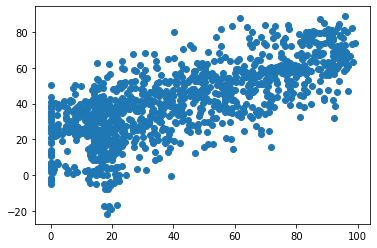

In [184]:
model = LinearRegression()
model.fit(x_train, y_train)
linreg_preds = model.predict(x_test)
plt.scatter(y_test, linreg_preds)

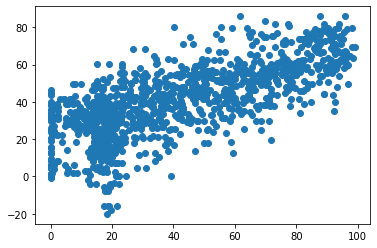

In [185]:
model = BayesianRidge()
model.fit(x_train, y_train)
br_preds = model.predict(x_test)
plt.scatter(y_test, br_preds)

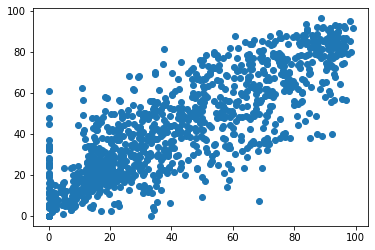

In [186]:
model = KNeighborsRegressor(5)
model.fit(x_train, y_train)
knn_preds = model.predict(x_test)
plt.scatter(y_test, knn_preds)

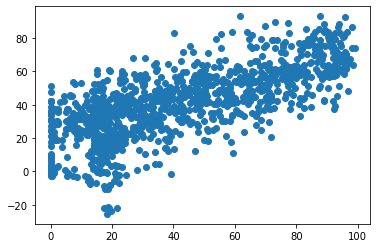

In [196]:
model = SVR(kernel='linear')
model.fit(x_train, y_train)
svr_preds = model.predict(x_test)
plt.scatter(y_test, svr_preds)

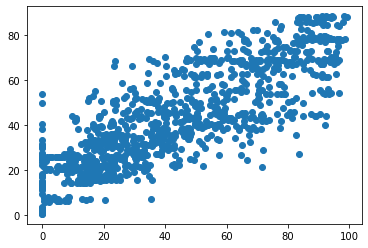

In [188]:
model = RandomForestRegressor(max_depth = 6)
model.fit(x_train, y_train)
rf_preds = model.predict(x_test)
plt.scatter(y_test, rf_preds)

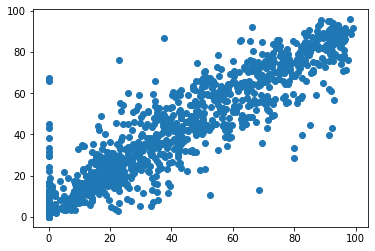

In [189]:
model = RandomForestRegressor(n_estimators=1024)
model.fit(x_train, y_train)
rf_preds = model.predict(x_test)
plt.scatter(y_test, rf_preds)

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


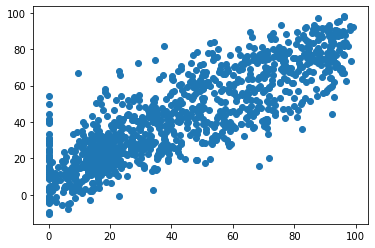

In [191]:
model = MLPRegressor(batch_size=16, learning_rate='invscaling', learning_rate_init=0.001, solver='lbfgs', max_iter=10000)
model.fit(x_train, y_train)
rf_preds = model.predict(x_test)
plt.scatter(y_test, rf_preds)